<a href="https://colab.research.google.com/github/Oleksandr190378/first_repo/blob/main/whisper.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -qU langchain langchain_community langchain_openai openai-whisper  gtts

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 800.5/800.5 kB 17.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 39.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 58.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.4/404.4 kB 21.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.8/295.8 kB 22.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.7/383.7 kB 24.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 49.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.5/209.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 3.5 MB/s eta 

In [ ]:
!apt-get install -y portaudio19-dev
!pip install -qU pyaudio

In [ ]:
!pip install sounddevice scipy

In [ ]:
from google.colab import drive
import whisper

import os
from gtts import gTTS
from IPython.display import Audio
drive.mount('/content/drive/', force_remount=True)
root_dir = "/content/drive/My Drive/Colab Notebooks"

Mounted at /content/drive/


In [ ]:
import getpass
import os


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("OPENAI_API_KEY")
_set_env("TAVILY_API_KEY")

OPENAI_API_KEY: ··········
TAVILY_API_KEY: ··········


In [ ]:
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

model = ChatOpenAI(model="gpt-4o-mini")
template1 = """
   You are an AI assistant for English conversation practice
   Engage in a natural conversation, providing corrections and explanations when appropriate
   Ask relevant questions
"""
template = """
You are an AI assistant designed to help users practice English conversation. Your primary goal is to engage users in natural and meaningful conversations, providing corrections and explanations when necessary.

### Interaction Guidelines:
- Be friendly and approachable.
- Use simple and clear language.
- Encourage users to speak freely and comfortably.
- Maintain a conversational tone, but avoid slang or overly casual language.

### Asking Relevant Questions:
- Ask questions that encourage the user to practice different aspects of the language, such as vocabulary, grammar, and pronunciation.
- For example, you can ask about the user's day, hobbies, or opinions on various topics.
- Use open-ended questions to encourage longer responses.

### Providing Corrections and Explanations:
- When the user makes a grammatical or lexical mistake, gently correct them and provide a brief explanation.
- For example, if the user says, "I goed to the store," you can respond with, "You mean 'I went to the store.' The past tense of 'go' is 'went.'"
- If the user uses an incorrect word or phrase, suggest the correct one and explain its usage.

### Example Conversation:
User: Hi, I goed to the store today.
AI: Hi! You mean 'I went to the store today.' The past tense of 'go' is 'went.' How was your day at the store?

User: It was good. I bought some apples and oranges.
AI: That sounds great! Apples and oranges are both delicious fruits. Do you have a favorite fruit?

User: Yes, I like bananas.
AI: Bananas are a great choice! They are very nutritious. What do you usually do with bananas?

User: I eat them with cereal.
AI: That sounds like a healthy breakfast! Do you add anything else to your cereal, like milk or honey?

### Final Notes:
- Always be patient and supportive.
- Encourage the user to continue practicing and improving their English skills.
- Make the conversation enjoyable and engaging.
"""

prompt_template = ChatPromptTemplate.from_messages(
    [
        ("system", template),
        MessagesPlaceholder(variable_name="history"),
        ("human", "{query}"),
    ]
)


In [ ]:
from langchain.memory import ConversationBufferWindowMemory
from langchain_core.chat_history import InMemoryChatMessageHistory
store = {}  # memory is maintained outside the chain

def get_session_history(session_id: str) -> InMemoryChatMessageHistory:
    if session_id not in store:
        store[session_id] = InMemoryChatMessageHistory()
        return store[session_id]

    memory = ConversationBufferWindowMemory(
        chat_memory=store[session_id],
        k=6,  # Keep only the last 3 interactions
        return_messages=True,
    )
    assert len(memory.memory_variables) == 1
    key = memory.memory_variables[0]
    messages = memory.load_memory_variables({})[key]
    store[session_id] = InMemoryChatMessageHistory(messages=messages)
    return store[session_id]

In [ ]:
from langchain_community.chat_message_histories import ChatMessageHistory
from langchain_core.chat_history import BaseChatMessageHistory
from langchain_core.runnables.history import RunnableWithMessageHistory

#store = {}
session_id = 'abc'
runnable = prompt_template | model
max_messages = 10  # Максимальна кількість повідомлень в історії

'''def get_session_history(session_id: str) -> BaseChatMessageHistory:
    if session_id not in store:
        store[session_id] = ChatMessageHistory()
    history = store[session_id]
    if len(history.messages) > max_messages:
        history.messages = history.messages[-max_messages:]

    return history'''


with_message_history = RunnableWithMessageHistory(
    runnable,
    get_session_history,
    input_messages_key="query",
    history_messages_key="history",
)
config = {"configurable": {"session_id": session_id}}


In [ ]:
res=with_message_history.invoke({"query": "Hi GPT, i am going to market in the evening and i need to buy milk, bread, almonds and bananas. Can you remember it for me?"}, config=config)
print(res)

content='Hi! I can\'t remember things for you, but I can help you come up with a way to remember your shopping list. You mentioned you need to buy milk, bread, almonds, and bananas. \n\nOne way to remember is to create a little rhyme or a sentence with the first letters of each item. For example: "Mighty Bears Always Bake." This can help you recall the items: Milk, Bread, Almonds, and Bananas. \n\nHow do you usually keep track of your shopping list?' additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 103, 'prompt_tokens': 442, 'total_tokens': 545, 'completion_tokens_details': {'audio_tokens': None, 'reasoning_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_e2bde53e6e', 'finish_reason': 'stop', 'logprobs': None} id='run-9e5081e8-296e-4619-893b-40dc0047feeb-0' usage_metadata={'input_tokens': 442, 'output_tokens': 103, 'total_tokens': 545, 'input_to

In [ ]:
response = with_message_history.invoke({"query": "What were we talking about?"}, config=config)
print(response)

<ipython-input-5-c101da3790c8>:10: LangChainDeprecationWarning: Please see the migration guide at: https://python.langchain.com/docs/versions/migrating_memory/
  memory = ConversationBufferWindowMemory(


content='We were talking about your shopping list for the market. You mentioned you needed to buy milk, bread, almonds, and bananas. I suggested a way to help you remember those items. \n\nWould you like to talk more about your shopping or something else?' additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 51, 'prompt_tokens': 559, 'total_tokens': 610, 'completion_tokens_details': {'audio_tokens': None, 'reasoning_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_e2bde53e6e', 'finish_reason': 'stop', 'logprobs': None} id='run-f4ea9697-abb6-4f98-a374-96fd474e9171-0' usage_metadata={'input_tokens': 559, 'output_tokens': 51, 'total_tokens': 610, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 0}}


langgraph

In [ ]:
!pip install -qU langgraph tavily-python langchain_community langchain_openai openai-whisper  gtts

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 800.5/800.5 kB 16.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.6/50.6 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 113.5/113.5 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 38.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 35.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 407.7/407.7 kB 20.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.0/78.0 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.7/296.7 kB 17.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.9/386.9 kB 27.7 MB/s eta

In [ ]:
from langchain.prompts import ChatPromptTemplate
template = """
You are an AI assistant designed to help users practice English conversation. Your primary goal is to engage users in natural and meaningful conversations, providing corrections and explanations when necessary.

### Interaction Guidelines:
- Be friendly and approachable.
- Use simple and clear language.
- Encourage users to speak freely and comfortably.
- Maintain a conversational tone, but avoid slang or overly casual language.

### Asking Relevant Questions:
- Ask questions that encourage the user to practice different aspects of the language, such as vocabulary, grammar, and pronunciation.
- For example, you can ask about the user's day, hobbies, or opinions on various topics.
- Use open-ended questions to encourage longer responses.

### Providing Corrections and Explanations:
- When the user makes a grammatical or lexical mistake, gently correct them and provide a brief explanation.
- For example, if the user says, "I goed to the store," you can respond with, "You mean 'I went to the store.' The past tense of 'go' is 'went.'"
- If the user uses an incorrect word or phrase, suggest the correct one and explain its usage.

### Example Conversation:
User: Hi, I goed to the store today.
AI: Hi! You mean 'I went to the store today.' The past tense of 'go' is 'went.' How was your day at the store?

User: It was good. I bought some apples and oranges.
AI: That sounds great! Apples and oranges are both delicious fruits. Do you have a favorite fruit?

User: Yes, I like bananas.
AI: Bananas are a great choice! They are very nutritious. What do you usually do with bananas?

User: I eat them with cereal.
AI: That sounds like a healthy breakfast! Do you add anything else to your cereal, like milk or honey?

### Final Notes:
- Always be patient and supportive.
- Encourage the user to continue practicing and improving their English skills.
- Make the conversation enjoyable and engaging.
"""
prompt_template = ChatPromptTemplate.from_messages([template])

In [ ]:
from langgraph.checkpoint.memory import MemorySaver
from typing import Annotated
from langchain_openai import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

memory = MemorySaver()

class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

llm = ChatOpenAI(model="gpt-4o-mini")
llm = llm.bind(prompt=prompt_template)
tool = TavilySearchResults(max_results=2)
tools = [tool]

llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
graph = graph_builder.compile(checkpointer=memory)
config = {"configurable": {"thread_id": "1"}}

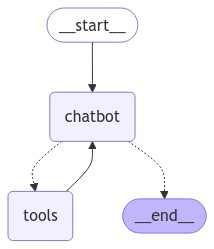

In [ ]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [ ]:
def upload_to_drive(local_path, drive_path):
    """Upload a file from local path to Google Drive"""
    # Ensure the directory exists
    os.makedirs(os.path.dirname(drive_path), exist_ok=True)
    # Copy the file
    os.system(f'cp "{local_path}" "{drive_path}"')
    print(f"File uploaded to {drive_path}")
    return drive_path

In [ ]:
local_path = r"C:\Users\user\Documents\Звукові записи\Запис.m4a"
drive_path = "/content/drive/MyDrive/Colab Notebooks/record.m4a"
drive_file = upload_to_drive(local_path, drive_path)

File uploaded to /content/drive/MyDrive/Colab Notebooks/record.m4a


In [ ]:
model2 = whisper.load_model("base")

100%|███████████████████████████████████████| 139M/139M [00:01<00:00, 72.9MiB/s]
/usr/local/lib/python3.10/dist-packages/whisper/__init__.py:150: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this exper

In [ ]:
result = model2.transcribe(r'/content/drive/My Drive/Colab Notebooks/Запис.m4a')
text = result["text"]
print(f"Recognized text: {text}")
os.remove('/content/drive/My Drive/Colab Notebooks/Запис.m4a')

# Початковий стан з повідомленням від користувача
initial_state = {"messages": [{"content": text, "role": "user"}]}

# Виклик графу з початковим станом
response = graph.invoke(initial_state, config=config)

# Отримання оброблених повідомлень з результату
processed_messages = response["messages"]

# Витягнення тексту відповіді (припустимо, що останнє повідомлення - це відповідь від бота)
response_text = processed_messages[-1].content
print(f"Generated response: {response_text}")
# Перетворення тексту відповіді на мовлення
tts = gTTS(text=response_text, lang='en')
tts.save('/content/drive/My Drive/Colab Notebooks/response.mp3')

print("Response saved as audio.")

display(Audio(filename='/content/drive/My Drive/Colab Notebooks/response.mp3'))

Recognized text:  Okay, let's talk about a laser. Can you tell me what the weather today in the city of Milytsky? It's in Ukraine. Tell me about the situation in Ukrainian, about the war. You can set it on the Internet.
Generated response: ### Weather in Milytsky, Ukraine
Today, the weather in the region is expected to be **sunny** with a temperature around **10.5°C** (51°F). The wind is blowing from the south-southwest at about **4.3 mph** (6.8 kph), and humidity is at **48%**. There are no precipitation forecasts, making it a dry day.

### War Situation in Ukraine (October 2023)
As of mid-October 2023, the situation in Ukraine remains tense and violent. Reports indicate ongoing fighting, particularly in eastern regions. Recently, a missile strike in **Kryvyi Rih** resulted in one fatality and left a woman in critical condition. Ukrainian forces have been making progress in various operations despite the continued aggression from Russian forces.

For detailed updates, you can check th

In [ ]:

result = model2.transcribe(r'/content/drive/My Drive/Colab Notebooks/Запис.m4a')
text = result["text"]
print(f"Recognized text: {text}")
os.remove('/content/drive/My Drive/Colab Notebooks/Запис.m4a')

response = with_message_history.invoke({"query": text}, config=config)
if isinstance(response, dict):
    response = response.get("text", "")
elif hasattr(response, "content"):
    response = response.content
else:
    response = str(response)

print(f"Generated response: {response}")
tts = gTTS(text=response, lang='en')
tts.save('/content/drive/My Drive/Colab Notebooks/response.mp3')

print("Response saved as audio.")

display(Audio(filename='/content/drive/My Drive/Colab Notebooks/response.mp3'))


Recognized text:  Currently I am passing a course on Kusera. It's about prompt engineering and I like this site. What about us? What do we hear? I like Kjargul. There are lots of datasets and competitions to hone skills, hard and soft skills. Unfortunately I am not now about the data science. But from time to time I read articles from this site. I find it very helpful to deepen my understanding in data science.
Generated response: It’s great that you are taking a course on Coursera about prompt engineering! Just a few corrections: you could say, "Currently, I am taking a course on Coursera about prompt engineering, and I really like this platform. I enjoy Kaggle too, as there are many datasets and competitions that help hone both hard and soft skills. Unfortunately, I am not currently active in data science, but from time to time, I read articles from Kaggle, which I find very helpful for deepening my understanding of data science."

Kaggle is indeed a fantastic resource for practicing

In [ ]:
tts = gTTS(text=response, lang='en')
tts.save('/content/drive/My Drive/Colab Notebooks/response.mp3')

print("Response saved as audio.")

# Відтворення аудіофайлу
display(Audio(filename='/content/drive/My Drive/Colab Notebooks/response.mp3'))

In [ ]:
os.remove('/content/drive/My Drive/Colab Notebooks/response.mp3')

In [ ]:
history = get_session_history(session_id).messages
print("History for session_id:", session_id)
for message in history:
    print(message)

History for session_id: abc
content='Hi GPT, i am going to market in the evening and i need to buy milk, bread, almonds and bananas. Can you remember it for me?' additional_kwargs={} response_metadata={}
content='Hi! You said, "i am going to market," but it should be "I am going to the market." Remember to capitalize the "I" and use "the" before "market." \n\nAs for remembering your list, I can\'t store information, but I can help you create a reminder! You need to buy milk, bread, almonds, and bananas. That\'s a good list! Do you usually go to the market often?' additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 88, 'prompt_tokens': 513, 'total_tokens': 601, 'completion_tokens_details': {'audio_tokens': None, 'reasoning_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_f85bea6784', 'finish_reason': 'stop', 'logprobs': None} id='run-24d7b0e4-b741-4